# Process SASSIE ocean model granules

In [1]:
import tarfile
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import xarray as xr
import netCDF4 as nc4
from datetime import datetime, timedelta

## import ECCO utils
import sys
sys.path.append('/Users/mzahn/github_others/ECCOv4-py')
import ecco_v4_py as ecco

ECCO github docs: https://github.com/ECCO-GROUP/ECCOv4-py/blob/master/ecco_v4_py/netcdf_product_generation.py

*Info from Ian/Mike:*

TIME<br>
data.cal start time is 1992-01-01<br>
Start time of the model is 5790000 (22.0319 years after 1992-01-01)<br>
Which is 2014-01-06T16:00:00<br>
Model simulation goes to around end of 2021<br>

FILES<br>
Each gz file has 14 files, each for one day<br>
199 (files)*14 (days per gz file) = 2,786 (days)/365 (days per year)= 7.6329 years

From *.meta file:
 nDims = [   2 ];
 dimList = [
         40,         1,        40,
     102600,         1,    102600
 ];
 dataprec = [ 'float32' ];
 nrecords = [          3 ];
 timeStepNumber = [    5810400 ];
 timeInterval = [  6.971616000000E+08  6.972480000000E+08 ];
 missingValue = [ -9.99000000000000E+02 ];
 nFlds = [    3 ];
 fldList = {
 'SIarea  ' 'SIheff  ' 'SIhsnow '
 };


## ECCO routines 

### routines to convert between SASSIE N1 faces and compact

In [2]:
def load_sassie_N1_field(file_dir, fname, nk=1, skip=0):
    num_cols = 680*4 + 1080
    num_rows = 1080
    
    time_level = int(fname.split('.data')[0].split('.')[-1])
    
    tmp_compact = ecco.load_binary_array(file_dir, fname, \
                                    num_rows, num_cols, nk=nk, skip=skip, filetype='>f4')

    return tmp_compact, time_level

In [3]:
def sassie_n1_compact_to_faces_2D(sassie_n1_compact):
    sassie_faces = dict()
    n = 680
    
    # Face 1 
    start_row = 0
    end_row = n
    sassie_faces[1] = sassie_n1_compact[start_row:end_row,:]

    # Face 2
    start_row = end_row
    end_row = start_row + n

    sassie_faces[2] = sassie_n1_compact[start_row:end_row,:]
    
    # Face 3
    start_row = end_row
    end_row = start_row + 1080
    sassie_faces[3] = sassie_n1_compact[start_row:end_row:,:]
    
    #Face 4
    start_row = end_row
    end_row = end_row + 680
    sassie_faces[4] = sassie_n1_compact[start_row:end_row].reshape(1080, n)

    #Face 5
    start_row = end_row
    end_row = end_row + 680
    sassie_faces[5] = sassie_n1_compact[start_row:end_row].reshape(1080, n)

    return sassie_faces

In [4]:
def sassie_n1_compact_to_faces_3D(sassie_n1_compact):
    sassie_faces = dict()
    n = 680
    
    # Face 1 
    start_row = 0
    end_row = n
    sassie_faces[1] = sassie_n1_compact[:,start_row:end_row,:]

    # Face 2
    start_row = end_row
    end_row = start_row + n
    sassie_faces[2] = sassie_n1_compact[:,start_row:end_row,:]
    
    # Face 3
    start_row = end_row
    end_row = start_row + 1080
    sassie_faces[3] = sassie_n1_compact[:,start_row:end_row:,:]
    
    #Face 4
    start_row = end_row
    end_row = end_row + 680
    sassie_faces[4] = sassie_n1_compact[:,start_row:end_row].reshape(90, 1080, n)

    #Face 5
    start_row = end_row
    end_row = end_row + 680
    sassie_faces[5] = sassie_n1_compact[:,start_row:end_row].reshape(90, 1080, n)

    return sassie_faces

In [5]:
## function to slice small pieces from Faces 1 and 4 and combine them to the Arctic Face 3
def combine_sassie_N1_faces_to_HHv2_2D(face_arr):
    # dimensions of the final Arctic HH field. 535+185+1080=1800
    new_arr = np.zeros((1080, 1800)) 
    # cut out sections we want and assign them to location on HH
    new_arr[:, 185:185 + 1080] = face_arr[3]
    # rotate Face 1 to line up with orientation of Face 3
    new_arr[:, 0:185] = np.flipud(face_arr[1][-185:,:].T) # flip and transpose
    new_arr[:, 185 + 1080:] = face_arr[4][:,:535]

    new_arr = np.rot90(new_arr,2) # rotate it 180 so Greenland/AK are on bottom
    return new_arr

In [11]:
## function to slice small pieces from Faces 1 and 4 and combine them to the Arctic Face 3
def combine_sassie_N1_faces_to_HHv2_3D(face_arr):
    # dimensions of the final Arctic HH field. 535+185+1080=1800 ; 90 vertical levels
    new_arr = np.zeros((90, 1080, 1800)) 
    # cut out sections we want and assign them to location on HH
    new_arr[:, :, 185:185 + 1080] = face_arr[3]
    # rotate Face 1 to line up with orientation of Face 3
    new_arr[:, :, 0:185] = np.transpose(face_arr[1][:,-185:,::-1],axes=(0,2,1)) # flip and transpose
    new_arr[:, :, 185 + 1080:] = face_arr[4][:,:,:535]

    new_arr = np.rot90(new_arr,2,axes=(1,2)) # rotate it 180 so Greenland/AK are on bottom
    return new_arr

In [13]:
def plot_sassie_HHv2_3D(face_arr, depth_level=0, vmin=None, vmax=None,\
    cmap='jet', axs = None, \
    show_colorbar=True):

    tmp = combine_sassie_N1_faces_to_HHv2_3D(face_arr)

    if vmin == None:
        vmin = np.min(tmp)
    if vmax == None:
        vmax = np.max(tmp)

    if axs == None:
        plt.imshow(tmp[depth_level,:,:], origin='lower', interpolation='none',vmin=vmin,vmax=vmax, cmap=cmap)
        if show_colorbar:
            plt.colorbar()

    else:
        im1 = axs.imshow(tmp[depth_level,:,:], origin='lower', interpolation='none',vmin=vmin,vmax=vmax, cmap=cmap)
        fig = plt.gcf()
        if show_colorbar:
            fig.colorbar(im1, ax=axs)

In [15]:
def make_2D_HHv2_da(field_HH, model_grid_ds, da_name='NAME'):
    tmp_da = xr.DataArray([field_HH], dims=['time','j','i'],\
                            coords={'XC': (('j','i'), model_grid_ds.XC.values),\
                                    'YC': (('j','i'), model_grid_ds.YC.values),\
                                    'time':(('time'),timestamp)})
    
    tmp_da.name = da_name
    
    return tmp_da

In [17]:
def make_3D_HHv2_da(field_HH, model_grid_ds, timestamp, da_name='NAME', k_face='center'):
    if k_face == 'center':
        tmp_da = xr.DataArray([field_HH], dims=['time', 'k','j','i'],\
                                coords={'XC': (('j','i'), model_grid_ds.XC.values),\
                                        'YC': (('j','i'), model_grid_ds.YC.values),\
                                        'Z': (('k'), model_grid_ds.Z.values),\
                                        'Zu':(('k'),model_grid_ds.Zu.values),\
                                        'Zl':(('k'),model_grid_ds.Zl.values),\
                                        'time':(('time'),timestamp)})
        tmp_da['k'].attrs['axis']  = 'Z'

    elif k_face == 'top':
        tmp_da = xr.DataArray([field_HH], dims=['time','k_l','j','i'],\
                                coords={'XC': (('j','i'), model_grid_ds.XC.values),\
                                        'YC': (('j','i'), model_grid_ds.YC.values),\
                                        'Z': (('k'), model_grid_ds.Z.values),\
                                        'Zu':(('k'),model_grid_ds.Zu.values),\
                                        'Zl':(('k'),model_grid_ds.Zl.values),\
                                        'time':(('time'),timestamp)})
        tmp_da['k_l'].attrs['axis']  = 'Z'

    elif k_face == 'bottom':
        tmp_da = xr.DataArray([field_HH], dims=['time','k_u','j','i','time'],\
                                coords={'XC': (('j','i'), model_grid_ds.XC.values),\
                                        'YC': (('j','i'), model_grid_ds.YC.values),\
                                        'Z': (('k'), model_grid_ds.Z.values),\
                                        'Zu':(('k'),model_grid_ds.Zu.values),\
                                        'Zl':(('k'),model_grid_ds.Zl.values),\
                                        'time':(('time'),timestamp)})
        tmp_da['k_u'].attrs['axis']  = 'Z'


    tmp_da['Z'].attrs['long_name'] = 'grid cell depth at center'
    tmp_da['Zu'].attrs['long_name'] = 'grid cell depth at bottom'
    tmp_da['Zl'].attrs['long_name'] = 'grid cell depth at top'

    tmp_da['Z'].attrs['units'] = 'm'
    tmp_da['Zl'].attrs['units'] = 'm'
    tmp_da['Zu'].attrs['units'] = 'm'

    tmp_da.name = da_name
 #   tmp_da = add_geo_metadata(tmp_da)

    return tmp_da

In [19]:
def timestamp_from_iter_num(iter_num):
    """
    takes the model iteration that was pulled from the data's filename and converts it to its equivalent datetime
    """
    ## Start time of the model is 5790000 (22.0319 years after 1992-01-01)
    ## there are 120 seconds for each iteration and 86400 seconds per day
    ## take the iteration number, convert to seconds, and calculate number of days since start of model
    
    num_days_since_start = iter_num*120 / 86400 ## divide iter_number by 86400 which is equal to the number of seconds in a day
    model_start_time = datetime(1992,1,1) # data.cal start time is 1992-01-01
    
    timestamp = np.array([model_start_time + timedelta(days=num_days_since_start)], dtype='datetime64[ns]')
    
    return timestamp

In [21]:
def unpack_tar_gz_files(data_dir):
    ## pull list of all tar.gz files in directory
    tar_gz_files = list(data_dir.glob('*.tar.gz'))
    
    ## unzip targz file
    for file_path in tar_gz_files:
        tar = tarfile.open(file_path, "r:gz")
        tar.extractall(data_dir) # save files to same directory
        tar.close()

In [23]:
def create_encoding(ecco_ds, output_array_precision = np.float32):
    
    # Create NetCDF encoding directives
    # ---------------------------------------------
    # print('\n... creating variable encodings')
    # ... data variable encoding directives
    
    # Define fill values for NaN
    if output_array_precision == np.float32:
        netcdf_fill_value = nc4.default_fillvals['f4']

    elif output_array_precision == np.float64:
        netcdf_fill_value = nc4.default_fillvals['f8']
    
    dv_encoding = dict()
    for dv in ecco_ds.data_vars:
        dv_encoding[dv] =  {'zlib':True, \
                            'complevel':5,\
                            'shuffle':True,\
                            '_FillValue':netcdf_fill_value}

    # ... coordinate encoding directives
    # print('\n... creating coordinate encodings')
    coord_encoding = dict()
    for coord in ecco_ds.coords:
        # set default no fill value for coordinate
        if output_array_precision == np.float32:
            coord_encoding[coord] = {'_FillValue':None, 'dtype':'float32'}
        elif output_array_precision == np.float64:
            coord_encoding[coord] = {'_FillValue':None, 'dtype':'float64'}

        # force 64 bit ints to be 32 bit ints
        if (ecco_ds[coord].values.dtype == np.int32) or \
           (ecco_ds[coord].values.dtype == np.int64) :
            coord_encoding[coord]['dtype'] ='int32'

        # fix encoding of time
        if coord == 'time' or coord == 'time_bnds':
            coord_encoding[coord]['dtype'] ='int32'

            if 'units' in ecco_ds[coord].attrs:
                # apply units as encoding for time
                coord_encoding[coord]['units'] = ecco_ds[coord].attrs['units']
                # delete from the attributes list
                del ecco_ds[coord].attrs['units']

        elif coord == 'time_step':
            coord_encoding[coord]['dtype'] ='int32'

    # ... combined data variable and coordinate encoding directives
    encoding = {**dv_encoding, **coord_encoding}

    return encoding

In [25]:
def process_3D_variable(data_dir, filename, n_k, n_skip, var_name, sassie_n1_geometry_ds, k_face='center'):
    ## process binary data to compact format
    data_compact, iter_num = load_sassie_N1_field(str(data_dir), filename, nk=n_k, skip=n_skip)
    
    ## convert compact format to 5 faces
    data_faces = sassie_n1_compact_to_faces_3D(data_compact)
    
    ## convert faces to HHv2 Arctic rectangle
    var_HHv2 = combine_sassie_N1_faces_to_HHv2_3D(data_faces)
    
    ## add timestamp to dataset
    timestamp = timestamp_from_iter_num(iter_num)
    
    var_HHv2_da = make_3D_HHv2_da(var_HHv2, sassie_n1_geometry_ds, timestamp, da_name=var_name, k_face=k_face)
    
    return var_HHv2_da, timestamp

In [27]:
def process_2D_variable(data_dir, filename, n_k, n_skip, var_name, sassie_n1_geometry_ds):
    ## process binary data to compact format
    data_compact, iter_num = load_sassie_N1_field(str(data_dir), filename, nk=n_k, skip=n_skip)
    
    ## convert compact format to 5 faces
    data_faces = sassie_n1_compact_to_faces_2D(data_compact)
    
    ## convert faces to HHv2 Arctic rectangle
    var_HHv2 = combine_sassie_N1_faces_to_HHv2_2D(data_faces)
    
    ## add timestamp to dataset
    timestamp = timestamp_from_iter_num(iter_num)
    
    var_HHv2_da = make_2D_HHv2_da(var_HHv2, sassie_n1_geometry_ds, timestamp, da_name=var_name)
    
    return var_HHv2_da, timestamp

In [46]:
def save_sassie_netcdf(var_HHv2_ds, output_dir, root_filename, var_name, timestamp):
    ## save netCDF files
    ## create output directory if it doesn't already exist
    output_dir_path = Path(output_dir + root_filename + "/" + var_name)
    output_dir_path.mkdir(parents=True, exist_ok=True) 
    
    encoding_var = create_encoding(var_HHv2_ds, output_array_precision = np.float32)
    yyyymmdd = str(timestamp)[2:6] + str(timestamp)[7:9] + str(timestamp)[10:12]
    var_filename_netcdf = "SASSIE_HH_" + var_name + "_" + yyyymmdd + ".nc"
    
    var_HHv2_ds.to_netcdf(output_dir_path / var_filename_netcdf, encoding = encoding_var)
    var_HHv2_ds.close()
    
    print('\n==== saved netcdf: ' + var_filename_netcdf + '====\n')

# Create routine to process files

In [32]:
## model geometry
sassie_n1_geometry_ds = xr.open_dataset('/Users/mzahn/data/SASSIE/GRID_GEOMETRY_SASSIE_HH_V1r1_native_llc1080.nc')

In [34]:
## open table that provides info for proper indexing based on desired variable
vars_table = pd.read_csv('sassie_variables_table.csv', index_col=False)

In [36]:
## where to save netCDFs with directories for each variable
output_dir = '/Users/mzahn/data/SASSIE/SASSIE_netcdfs/'

In [38]:
var_select = 'THETA'

In [40]:
## loop through each time step ------
table_select = vars_table[vars_table['variable'] == var_select]

## model data directories
sassie_llc1080_data_dir = '/Users/mzahn/data/SASSIE/SASSIE_examples/'
root_filename = table_select['root_filename'].values[0]
data_dir = Path(sassie_llc1080_data_dir + root_filename)

## ============
## code to pull compressed file from S3 bucket
## make sure if multiple variables come from the same files those files aren't downloaded twice
## ============

## unpack tar_gz files
# unpack_tar_gz_files(data_dir)

## loop through files
data_files = sort(list(data_dir.glob('*.data')))

for file in data_files:
    print('loading file: ', file)
    
    ## get variable name and filename
    var_name = table_select['variable'].values[0]
    filename = str(file).split('/')[-1]
    
    ## if the variable is 3D, there are 90 vertical levels; if it is 2D, nk=1
    ## use index from table to identify how many fields to skip
    if table_select['n_dims'].values == '3D':
        n_k = 90
        n_skip = table_select['field_index'].values[0] * 90 
        ## process dataset
        var_HHv2_da, timestamp = process_3D_variable(data_dir, filename, n_k, n_skip, var_name, sassie_n1_geometry_ds, k_face='center')
        
    elif table_select['n_dims'].values == '2D':
        n_k = 1
        n_skip = table_select['field_index'].values[0] * 1
        ## process dataset
        var_HHv2_da, timestamp = process_2D_variable(data_dir, filename, n_k, n_skip, var_name, sassie_n1_geometry_ds)

    ## save netcdf
    var_HHv2_ds = var_HHv2_da.to_dataset()
    save_sassie_netcdf(var_HHv2_ds, output_dir, root_filename, var_name, timestamp)

loading file:  /Users/mzahn/data/SASSIE/SASSIE_examples/ocean_state_3D_day_mean/ocean_state_3D_day_mean.0005802480.data
load_binary_array: loading file /Users/mzahn/data/SASSIE/SASSIE_examples/ocean_state_3D_day_mean/ocean_state_3D_day_mean.0005802480.data
load_binary_array: data array shape  (90, 3800, 1080)
load_binary_array: data array type  >f4

... saved netcdf: SASSIE_HH_THETA_20140124.nc
loading file:  /Users/mzahn/data/SASSIE/SASSIE_examples/ocean_state_3D_day_mean/ocean_state_3D_day_mean.0005806800.data
load_binary_array: loading file /Users/mzahn/data/SASSIE/SASSIE_examples/ocean_state_3D_day_mean/ocean_state_3D_day_mean.0005806800.data
load_binary_array: data array shape  (90, 3800, 1080)
load_binary_array: data array type  >f4

... saved netcdf: SASSIE_HH_THETA_20140130.nc
loading file:  /Users/mzahn/data/SASSIE/SASSIE_examples/ocean_state_3D_day_mean/ocean_state_3D_day_mean.0005801760.data
load_binary_array: loading file /Users/mzahn/data/SASSIE/SASSIE_examples/ocean_state

In [50]:
output_dir

'/Users/mzahn/data/SASSIE/SASSIE_netcdfs/'

In [54]:
tmp = xr.open_dataset('/Users/mzahn/data/SASSIE/SASSIE_netcdfs/ocean_state_3D_day_mean/THETA/SASSIE_HH_THETA_20140203.nc')

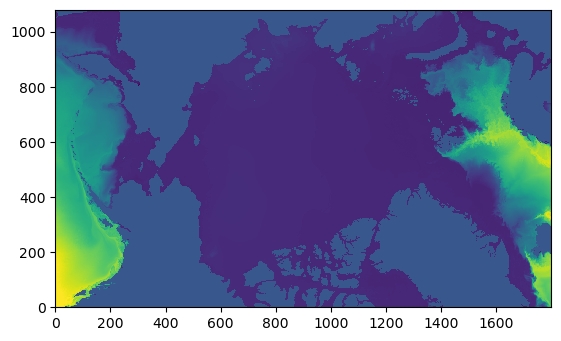

In [88]:
plt.imshow(tmp.THETA.isel(k=0,time=0), origin='lower', interpolation='none',vmin=-3,vmax=8)

In [78]:
import cartopy.crs as ccrs

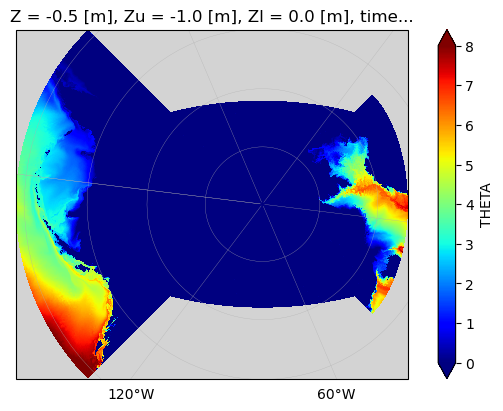

In [84]:
fig = plt.figure(figsize=(7,4), constrained_layout=True)
ax1 = fig.add_subplot(1,1,1, projection=ccrs.NorthPolarStereo(central_longitude = -83))
# ax1.set_extent([-75, -48, 68, 78], ccrs.PlateCarree())

tmp.THETA.isel(k=0,time=0).plot(x='XC',y='YC',ax=ax1,vmin=0,vmax=8,cmap='jet',transform=ccrs.PlateCarree())

ax1.set_facecolor('lightgray')
# ax1.set_title("depth=" + str(theta_350m.depth.values))
gl = ax1.gridlines(crs=ccrs.PlateCarree(), linewidth=0.2,draw_labels=True,x_inline=False, y_inline=False,\
                  xpadding=6,ypadding=6,rotate_labels=False)
gl.top_labels = False
gl.right_labels = False
gl.left_labels = False